In [1]:
%matplotlib inline

In [2]:
# filter the warning - created by pynndescent
import warnings
warnings.filterwarnings('ignore')

In [3]:
from importlib import reload

In [5]:
import nb_import_exp
nb_import_exp = reload(nb_import_exp)
import tools
tools = reload(tools)
import experiment_1
experiment_1 = reload(experiment_1)

In [6]:
from nb_import_exp import *

# abstract

This notebook is dedicated to running some code and conducting some exploratory experiments.

For example:
- run t-SNE on datasets usually embedded with t-SNE
- run force on same datasets
- develop a verified version of force in Python
- explore different types of initialisation for t-SNE

# datasets

- MNIST-2k
- MNIST-70k
- MNIST-fashion

<table>
    <tr>
        <th>dataset name</th>
        <th># of samples</th>
        <th># of classes</th>
        <th># of dimensions</th>
    </tr>        
    <tr>
        <td>MNIST-2k</td>
        <td>1797</td>
        <td>10</td>
        <td>64</td>
    </tr>        
    <tr>
        <td>MNIST-70k</td>
        <td>70k</td>
        <td>10</td>
        <td>784</td>
    </tr>        
    <tr>
        <td>MNIST-fasion</td>
        <td>70k</td>
        <td>10</td>
        <td>784</td>
    </tr>        

</table>

# 1. Running t-SNE

For this purpose, we are gonna use a state-of-the-art implementation of t-SNE, which implements the optimisations described in [10].

In [7]:
dataset = "mnist-2k" # could also be one of: "mnist-70k", "mnist-fashion", "macosko"
(X_train, y_train, X_test, y_test) = tools.get_dataset("mnist-2k")

In [8]:
tsne_opt_res = []

tnse = openTSNE.TSNE(n_jobs=8,
                    callbacks=lambda it, err, emb: tsne_opt_res.append((it, err)),
                    callbacks_every_iters=1,
                    )

This object can then run the optimisation. It takes:

<table>
    <tr>
        <th>dataset name</th>
        <th>user</th>
        <th>wall</th>
        <th>total</th>
    </tr>        
    <tr>
        <td>MNIST-2k</td>
        <td>3min 41s</td>
        <td>1min 5s</td>
        <td>3min 53s</td>
    </tr>
</table>


In [9]:
%time emb = tnse.fit(X_train)

CPU times: user 3min 37s, sys: 11.8 s, total: 3min 49s
Wall time: 1min 3s


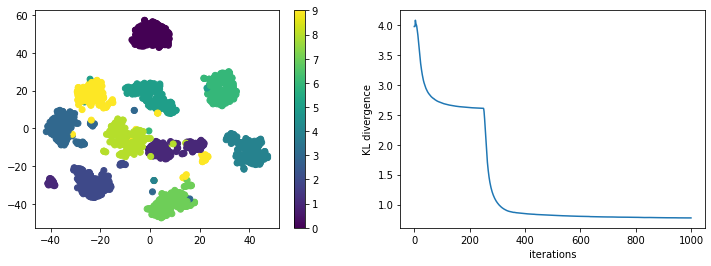

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

im = ax[0].scatter(emb[:,0], emb[:,1], c=y_train, rasterized=True)
fig.colorbar(im, ax=ax[0])

ax[1].plot(np.array(tsne_opt_res)[:,1])
ax[1].set_ylabel('KL divergence')
_=ax[1].set_xlabel('iterations')

# 2. Influence of the initialisation

In response to the problem of having different results for the t-SNE embedding in different runs, PCA initialisation has emerged as the solution for repeatibility. It is indeed, the initialisation that is chosen by default in the code above. It is however possible to investigate how different initialisation strategies affect the results.

Here, we look at random, pca and spectral embedding.

In [11]:
%time init_random = openTSNE.initialization.random(X_train)

CPU times: user 444 µs, sys: 149 µs, total: 593 µs
Wall time: 361 µs


In [12]:
%time init_pca = openTSNE.initialization.pca(X_train)

CPU times: user 39.2 ms, sys: 7.42 ms, total: 46.7 ms
Wall time: 12.7 ms


In [13]:
%time aff = openTSNE.affinity.PerplexityBasedNN(X_train, n_jobs=8)

CPU times: user 5.44 s, sys: 127 ms, total: 5.57 s
Wall time: 4.43 s


In [14]:
%time init_spectral = spectral_embedding(aff.P, n_components=2, eigen_solver='amg')

CPU times: user 1.21 s, sys: 46.5 ms, total: 1.26 s
Wall time: 325 ms


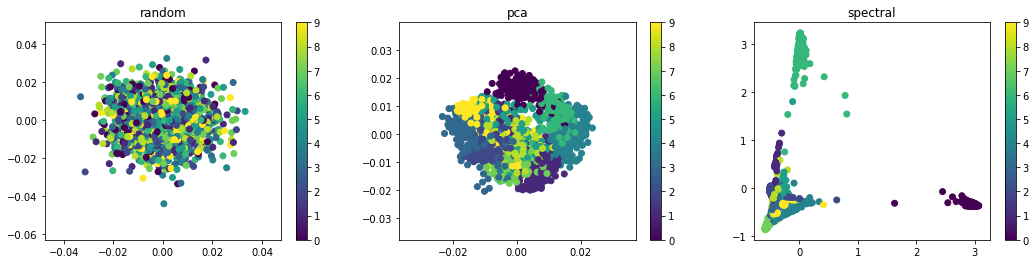

In [15]:
experiment_1.plot_inits(init_random, init_pca, init_spectral, y_train)

In [16]:
tsne_inits_res = []

In [17]:
%time tsne_init_random = experiment_1.optimize_embedding_with_init(init_random, aff, tsne_inits_res)

CPU times: user 4min, sys: 14.3 s, total: 4min 14s
Wall time: 1min 4s


In [18]:
%time tsne_init_pca = experiment_1.optimize_embedding_with_init(init_pca, aff, tsne_inits_res)

CPU times: user 3min 38s, sys: 12.3 s, total: 3min 51s
Wall time: 58.6 s


In [19]:
%time tsne_init_spectral = experiment_1.optimize_embedding_with_init(init_spectral, aff, tsne_inits_res)

CPU times: user 3min 39s, sys: 12.5 s, total: 3min 51s
Wall time: 58.9 s


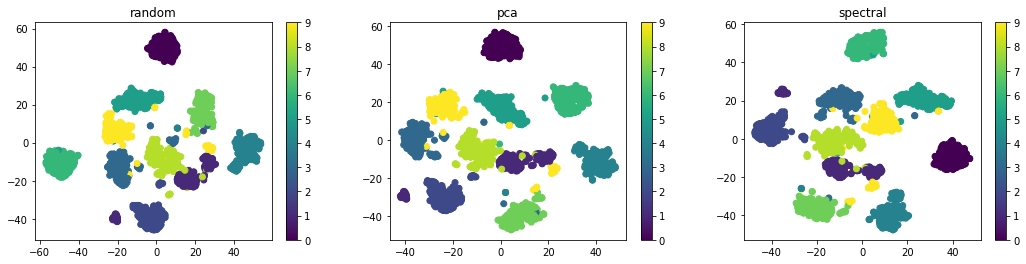

In [20]:
experiment_1.plot_inits_emb(tsne_init_random, tsne_init_pca, tsne_init_spectral, y_train)

In [21]:
tsne_inits_res_np = np.array(tsne_inits_res)

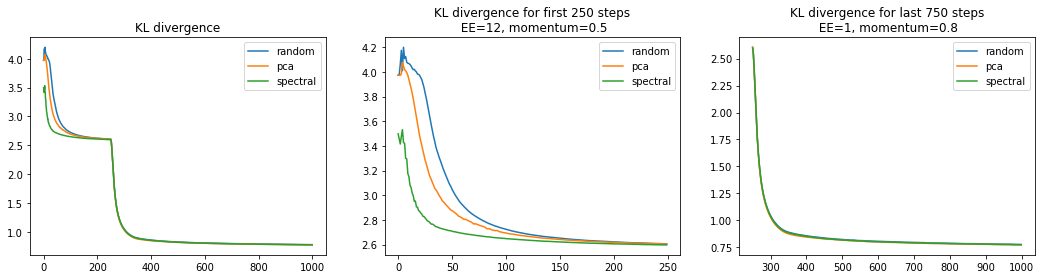

In [22]:
experiment_1.plot_inits_KL(tsne_inits_res_np)

In [23]:
print('init random KL:', tsne_inits_res_np[999,1])
print('init pca KL:', tsne_inits_res_np[1999,1])
print('init spectral KL:', tsne_inits_res_np[2999,1])

init random KL: 0.7760742881950087
init pca KL: 0.7717514847074387
init spectral KL: 0.7734677572135702


As we can see, the optimisation does end up producing a value for the KL divergence that is similar no matter the initialisation method used.

# number of neighbhour of same class in K-ANN

# influence of different initialisation

# comparison stress for t-SNE and force embeddings

# t-SNE gradient

The gradient of the cost is equal to:


$$\frac{\partial C}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)(1+\lVert y_i - y_j \rVert^2)^{-1}$$


which for one point $i$ takes into account the influence of all other points $j$. The shape of the gradient can be explored by looking at the contribution of 1 point to its norm:

$$\lVert \frac{\partial C_j}{\partial y_i} \rVert = \lVert (p_{ij} - q_{ij})(y_i - y_j)(1+\lVert y_i - y_j \rVert^2)^{-1} \rVert$$

If we set the two variables $x = \lVert x_i - x_j \rVert$ and $y = \lVert y_i - y_j \rVert$, we get:


$\lVert \frac{\partial C_j}{\partial y_i} \rVert = 4 \lVert F_{attr,i} - F_{rep,i} \rVert$

$F_{attr,i} = Z * p_{ij}q_{ij} Z (y_i-y_j)$

$F_{rep,i} = Z * q_{ij}^2 (y_i-y_j)$

$Z = \sum_{k \neq l} (1+ \lVert y_k - y_l \rVert^2)^{-1}$

$p_{i|j} = \frac{exp(-\lVert x_i - x_j \rVert^2/2\sigma_i^2)}{\sum_{k \neq i} exp(-\lVert x_i - x_k \rVert^2/2\sigma_i^2)}$


$p_{ij} = \frac{p_{i|j} + p_{j|i}}{2N}$

$q_{ij} = \frac{(1 + \lVert y_i - y_j \rVert^2)^{-1}}{\sum_{k \neq l} (1 + \lVert y_k - y_l \rVert^2)^{-1}}$



$p_{ij} = C_0 exp(-x^2/C_1)$

$q_{ij} = D_0 (1 + y^2)^{-1}$


$$\lVert \frac{\partial C_j}{\partial y_i} \rVert = (C_0 exp(-x^2/C_1) - D_0 (1 + y^2)^{-1}) \frac{y}{1+y^2}$$

$$\lVert \frac{\partial C_j}{\partial y_i} \rVert = \frac{C_0 y \exp(-x^2/C_1)}{1+y^2} - \frac{D_0 y}{(1+y^2)^2}$$

<font size="5">
Test
</font>


In [ ]:
C0 = 1
C1 = 1
D0 = 1

def gradient(x, y):
    A = C0 * y * np.exp(-x**2/C1) / (1+y**2)
    B = D0 * y / (1+y**2)**2
    
    return A - B

In [ ]:
N = 50
x = np.linspace(0,10,N)
y = np.linspace(0,10,N)
X,Y = np.meshgrid(x, y) # grid of point

In [ ]:
Z = gradient(X, Y) # evaluation of the function on the grid

In [ ]:
# plt.imshow(Z)

In [ ]:
from matplotlib import cm

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
res = ax.pcolor(x, y, Z, cmap=cm.RdBu)
fig.colorbar(res, ax=ax)

In [ ]:
from ipywidgets import interactive, IntSlider

In [ ]:
def plot_gradient(a, b, c, N):
    
    C0 = a
    C1 = b
    D0 = c

    def gradient(x, y):
        A = C0 * y * np.exp(-x**2/C1) / (1+y**2)
        B = D0 * y / (1+y**2)**2
        return A - B

    N = N
    x = np.linspace(0,10,N)
    y = np.linspace(0,10,N)
    X,Y = np.meshgrid(x, y) # grid of point

    Z = gradient(X, Y) # evaluation of the function on the grid
    
    fig, ax = plt.subplots(figsize=(6,6))
    res = ax.pcolor(x, y, Z, cmap=cm.RdBu)
    fig.colorbar(res, ax=ax)

In [ ]:
w = interactive(plot_gradient, a=IntSlider(1,1,10), b=IntSlider(1,1,10), c=IntSlider(1,1,10), 
                N=IntSlider(30,10,100), continuous_update=False)

In [ ]:
display(w)